In [1]:
NAME = "Julien Fer"
STUDENT_NUMBER = 10649441
EMAIL = "julien.fer88@gmail.com"

# Assignment 1: SIR Model (ODE)

In this assignment one learns to implement the SIR model without and with demography and one variant on this model. This is done for states of an epidemic and no epidemic. Below this cell one can find the different parts of the assignment

In [2]:
# import all the modules necessary for this assignment
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft
from math import ceil, cos, pi
import matplotlib.pyplot as plt

# set style plots and determine width in points for latex
plt.style.use("seaborn-darkgrid")

# update rcparams matplotlib to ensure same style for the different plots
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 12pt font in plots, to match 12pt font in document
        "axes.labelsize": 12,
        "font.size": 12,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        # set line style axis and line plots
        "lines.linewidth": 1,
        "axes.edgecolor": "0.15",
        "axes.linewidth": 1.25
}

plt.rcParams.update(nice_fonts)

# relative file path for saving figures
rel_path = "../../Latex/Intro to Computational Science/Assignment 1/images/"

## Problem 1: Numerical integration of the basic model

### 1.1 Exercise 1.1

Numerically integrate the ODEs for states of an epidemic and no epidemic. What is the parameter that determines if the infectious disease will become an epidemic? Provide phase space diagrams, with analysis, of the system.

In [3]:
def basic_SIR(y, t, beta, gamma):
    """
    Representation of ODE of SIR
    """
    
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = -(dIdt + dSdt)
    
    return [dSdt, dIdt, dRdt]


def plot_dynamics(ax, func, init_pop, t, beta, gamma, state):
    """
    Plots the dynamics for a given SIR model, initial populaiton, beta and gamma
    """
    # gives solution of ODE over a certain time interval for a given population, beta and gamma
    sol = odeint(func, init_pop, t, args=(beta, gamma))

    # plot
    ax.plot(t, sol[:, 0] / N, label="Susceptibles")
    ax.plot(t, sol[:, 1] / N, label="Infected")
    ax.plot(t, sol[:, 2] / N, label="Recoverd")
    ax.legend(loc="best")
    ax.set_xlabel("Time / days")
    ax.set_ylabel("Fraction of population")
    ax.set_title(r"SIR without demography ({ep})".format(ep = state))

def phase_plot(ax, func, t, beta, gamma, state):
    """
    Creates phase plot for a given SIR model, beta and gamma
    """
    
    # create vector for different initials values for infected
    I_step = 0.1 * N
    I_all = np.arange(I_step, N, I_step)
    I_all = np.insert(I_all, 0, 0.001 * N)

    # makes phase plot for the different initial values of infected
    for I_init in I_all:
        S_init = N - I_init - R0
        y0 = [S_init, I_init, R0]
        sol = odeint(func, y0, t, args=(beta, gamma))
        ax.plot(sol[:, 0] / N, sol[:, 1] / N, 'b-')
        ax.plot(sol[0,0] / N, sol[0,1] / N, 'ko')

    # create vector for different initials values for suceptibles
    # if there is an epidemic state make phase plot for the different inital values
    S_first = ceil(gamma / beta * 10) / 10
    if S_first < 1:
        S_step = 0.1 * N
        S_all = np.arange(S_first * N, N, S_step)
        S_all = np.insert(S_all, len(S_all), 0.999 * N)

        # makes phase plot for the different initial values of suceptibles
        # only for epidemic state
        I_init = 0.001 * N
        for S_init in S_all:
            R_init = N - S_init - I_init
            y0 = S_init, I_init, R_init
            sol = odeint(func, y0, t, args=(beta, gamma))
            ax.plot(sol[:, 0] / N, sol[:, 1] / N, 'b-')
            ax.plot(sol[0,0] / N, sol[0,1] / N, 'ko')
            
        # plot vertical line where gamma / beta
        ax.vlines(gamma / beta, 0.001, 1.05, colors='k', linestyles="dashed", linewidth=0.75)

    # creates diagonal line where R(0) = 0
    S_diagonal = [(N - I_init) / N for I_init in I_all]
    S_diagonal = np.array(S_diagonal[::-1])
    S_diagonal = np.insert(S_diagonal, 0, 0)
    I_diagonal = I_all[::-1] / N
    I_diagonal = np.insert(I_diagonal, 0, 1)
    ax.plot(S_diagonal, I_diagonal, 'k-')


    # creates horizontal line where I(0) = 0.001
    ax.hlines(0.001, 0, 1)
    
    # set limits axis and set title for axis and plot
    ax.set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))
    ax.set_xlabel("Fraction of Suceptibles (S)")
    ax.set_ylabel("Fraction of Infected (I)")
    ax.set_title(r"Phase plot SIR without demography ({ep})".format(ep = state))

    
def plot_SIR(func, init_pop, t, beta, gamma, state):
    """
    Plots the SIR model for a given initial population, 
    beta and gamma over a certain amounnt of time steps.
    Also plots the phaseplot.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    plot_dynamics(axes[0], func, init_pop, t, beta, gamma, state)
    phase_plot(axes[1,], func, t, beta, gamma, state)
    if state == "no epidemic":
        plt.savefig(f"{rel_path}SIR_without_demography_no_epidemic.pdf", format="pdf", bbox_inches="tight", dpi=300)
    else:
        plt.savefig(f"{rel_path}SIR_without_demography_{state}.pdf", format="pdf", bbox_inches="tight", dpi=300)
    plt.show()

Cell belows create plots for basic SIR model with epidemic state:

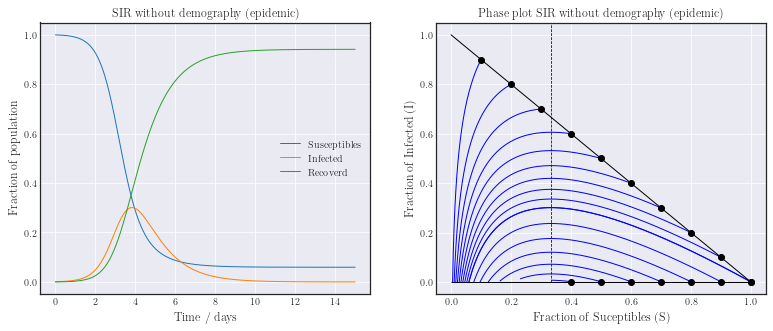

In [4]:
# total population, N.
N = 1000

# initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 0.001 * N, 0

# everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# intials condition for y and solution of ODE
y0 = [S0, I0, R0]

# contact rate, beta, and mean recovery rate, gamma, (in 1/days) epidemic state
beta_epidemic, gamma_epidemic = 3, 1

# a grid of time points (in days)
t = np.linspace(0, 15, 1000)

# make plots
plot_SIR(basic_SIR, y0, t, beta_epidemic, gamma_epidemic, "epidemic")

Cell belows plot basic SIR model with no epidemic state:

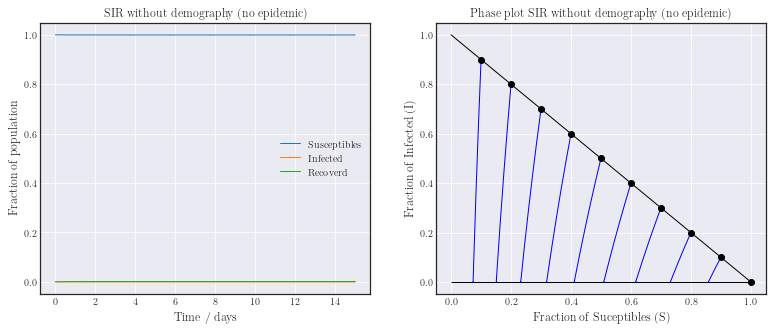

In [5]:
# # initial number of infected and recovered individuals, I0 and R0.
# I0_no_epidemic, R0_no_epidemic = 0.001 * N, 0

# # everyone else, S0, is susceptible to infection initially.
# S0_no_epidemic = N - I0_no_epidemic - R0_no_epidemic

# # intials condition for y and solution of ODE
# y0_no_epidemic = [S0_no_epidemic, I0_no_epidemic, R0_no_epidemic]

# contact rate, beta, and mean recovery rate, gamma, (in 1/days) non epidemic state
beta_no_epidemic, gamma_no_epidemic = 1, 3

plot_SIR(basic_SIR, y0, t, beta_no_epidemic, gamma_no_epidemic, "no epidemic")

### 1.2 Exercise 1.2

Given below is the historical data from a case of an influenza outbreak situation. The outbreak was in a boys school with a total of 763 boys. It also seems that one infected boy started the epidemic. Could you try to fit an SIR model to the data?

| **Day**   | 1 | 2 |  3  |  4  |  5  |  6  |  7  |  8  |  9  | 10  | 11 | 12 | 13 | 14  |
| --------- |---|---| --- | --- | --- | --- | --- | --- | --- | --- | ---| ---| ---| --- |
| **Number**| 3 | 8 |  28 |  75 | 221 | 291 | 255 | 235 | 190 | 125 | 70 | 28 | 12 |  5  |

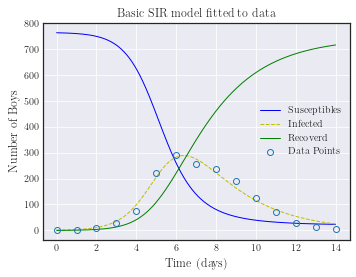

In [6]:
# set time interval (14 days starting from day 0) and the development of infected boys over the time interval
infected = np.array([1, 3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5])
t_infected = np.linspace(0, infected.size - 1, infected.size)

# time interval for solving ODEs when beta and gama are determined
t_ode = np.linspace(0, 14, 1000)

# total population, N.
N = 763

# initial number of infected and recovered individuals, I0 and R0.
I0, R0 = infected[0], 0

# everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# intials condition for y and solution of ODE
y0 = [S0, I0, R0]

# integrate given the inital population, returns the development of infected 
def fit_odeint(x, beta, gamma):
    return odeint(basic_SIR, y0, x, args=(beta, gamma))[:,1]

# fit function to given data in order to determine the parameters beta and gamma
par_opt, par_cov = curve_fit(fit_odeint, t_infected, infected)

# solve ODEs with the determined parameters
fitted = odeint(basic_SIR, y0, t_ode, args=(par_opt[0], par_opt[1]))

# plot the dynamics
plt.figure(figsize=(5.5, 4))
plt.plot(t_ode, fitted[:, 0] , 'b', label="Susceptibles")
plt.plot(t_ode, fitted[:, 1], "y--", label="Infected")
plt.plot(t_ode, fitted[:, 2], 'g', label="Recoverd")
plt.plot(t_infected, infected, 'o', mfc="none", label="Data Points")
plt.legend(loc="best")
plt.xlabel("Time (days)")
plt.ylabel("Number of Boys")
plt.title(r"Basic SIR model fitted to data")
plt.savefig(f"{rel_path}sir_fitted.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

### 1.3 Exercise 1.3

Can you propose a vaccination plan to prevent the epidemic?

An epidemic occurs when $S_{0}$ is larger than $\frac{1}{R_{0}}$ with $R_{0} = \frac{\beta}{\gamma}$. To prevent the epidemic from happening the vaccination plan should prevent S_{0} from being larger than $\frac{1}{R_{0}}$, resulting in the following equation:
\begin{equation*}
S_{0} < \frac{1}{R_{0}} = \frac{1}{3.71} \approx 0.269 = 26.9\%
\end{equation*}
To prevent the epidemic, at least least 73.1\% of the population should be vaccinated. For a school of 763 boys this means vaccinating at least 558 boys.

## Problem 2: Demography

Now we want to start to add more terms to our model. Lets start to consider demography i.e. Birth and death rates.

### 2.1 Excercise 1

Add birth and natural death rate term into model. (Hint: keep Npopulation constant). How does the dynamics change? Run the model to capture an endemic state. Do you see oscillatory behavior in the fraction of infected population? What are requirements to observe this behavior? What is the frequency and amplitude of these oscillations (Hint: use Fourier analysis)?

In [7]:
def demo_SIR(y, t, beta, gamma, mu):
    """
    Representation of ODE of SIR with demography
    i.e birth and death rates
    """
    
    S, I, R = y
    dSdt = mu * (I + R) - beta * S * I / N 
    dIdt = beta * S * I / N - (mu + gamma) * I
    dRdt = gamma * I - mu * R
    
    
    return [dSdt, dIdt, dRdt]

def plot_dyn_demo_SIR(ax, func, init_pop, t, beta, gamma, mu, state):
    """
    Plots the dynamics for a given SIR model, initial populaiton, beta and gamma
    """
    # gives solution of ODE over a certain time interval for a given population, beta and gamma
    sol = odeint(func, init_pop, t, args=(beta, gamma, mu))

    # plot
    ax.plot(t, sol[:, 0] / N, label="Susceptibles")
    ax.plot(t, sol[:, 1] / N, label="Infected")
    ax.plot(t, sol[:, 2] / N, label="Recoverd")
    ax.legend(loc="best")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Fraction of population")
    ax.set_title(r"SIR with demography ({ep})".format(ep = state))
    
    return sol

def phase_plot_demo_SIR(ax, func, t, beta, gamma, mu, state):
    """
    Creates phase plot for a given SIR model, beta and gamma
    """
    
    # create vector for different initials values for infected
    I_first = 0.1 * N
    I_step = 0.2 * N
    I_all = np.arange(I_first, N, I_step)
    I_all = np.insert(I_all, 0, 0.001 * N)

    # makes phase plot for the different initial values of infected
    for I_init in I_all:
        S_init = N - I_init - R0
        y0 = S_init, I_init, R0
        sol = odeint(func, y0, t, args=(beta, gamma, mu))
        ax.plot(sol[:, 0] / N, sol[:, 1] / N, 'b-')
        ax.plot(sol[0,0] / N, sol[0,1] / N, 'ko')

    # create vector for different initials values for suceptibles
    # if there is an epidemic state make phase plot for the different inital values
    S_first = ceil((gamma + mu) / beta * 10) / 10
    if S_first < 1:
        S_step = 0.2 * N
        S_all = np.arange(S_first * N, N, S_step)
        S_all = np.insert(S_all, len(S_all), 0.999 * N)

        # makes phase plot for the different initial values of suceptibles
        # only for epidemic state
        I_init = 0.001 * N
        for S_init in S_all:
            R_init = N - S_init - I_init
            y0 = S_init, I_init, R_init
            sol = odeint(func, y0, t, args=(beta, gamma, mu))
            ax.plot(sol[:, 0] / N, sol[:, 1] / N, 'b-')
            ax.plot(sol[0,0] / N, sol[0,1] / N, 'ko')
            ax.plot(sol[-1, 0] / N, sol[-1, 1] / N, "r.")
            
        # plot vertical line where (gamma + mu) / beta
        ax.vlines((gamma + mu) / beta, 0.001, 1.05, colors='k', linestyles="dashed", linewidth=0.5)

    # creates diagonal line where R(0) = 0
    S_diagonal = [(N - I_init) / N for I_init in I_all]
    S_diagonal = np.array(S_diagonal[::-1])
    S_diagonal = np.insert(S_diagonal, 0, 0)
    I_diagonal = I_all[::-1] / N
    I_diagonal = np.insert(I_diagonal, 0, 1)
    ax.plot(S_diagonal, I_diagonal, 'k-')
    
    # creates horizontal line where I(0) = 0.001
    ax.hlines(0.001, 0, 1)
    
    # set limits axis and set title for axis and plot
    ax.set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))
    ax.set_xlabel("Fraction of Suceptibles (S)")
    ax.set_ylabel("Fraction of Infected (I)")
    ax.set_title(r"SIR with demography phase plot ({ep})".format(ep = state))

    
def plot_demo_SIR(func, init_pop, t, beta, gamma, mu, state):
    """
    Plots the SIR model for a given initial population, 
    beta and gamma over a certain amounnt of time steps.
    Also plots the phaseplot.
    """

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    sol = plot_dyn_demo_SIR(axes[0], func, init_pop, t, beta, gamma, mu, state)
    phase_plot_demo_SIR(axes[1,], func, t, beta, gamma, mu, state)
    
    if state == "no epidemic":
        plt.savefig(f"{rel_path}SIR_with_demography_no_epidemic.pdf", format="pdf", bbox_inches="tight", dpi=300)
    else:
        plt.savefig(f"{rel_path}SIR_with_demography_{state}.pdf", format="pdf", bbox_inches="tight", dpi=300)
        
    plt.show()
        
    return sol

Cell below plots the demographical SIR model with an epidemic state

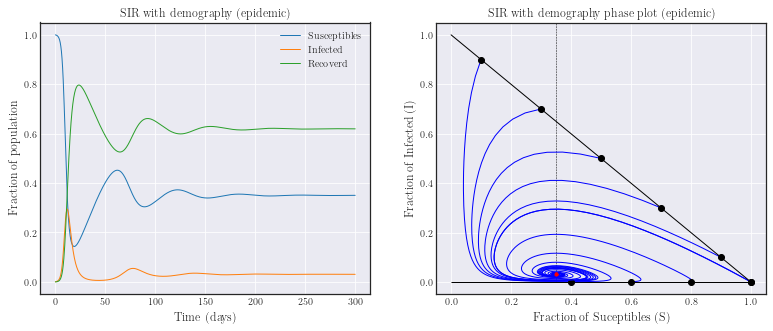

In [8]:
# total population, N.
N = 1000

# initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 0.001 * N, 0

# everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# intials condition for y and solution of ODE
y0 = [S0, I0, R0]

# set parameter values for epidemic state
mu = 1 / 60
beta2_epidemic = 1
gamma2_epidemic = 1 / 3

t = np.linspace(0, 300, 1000)

# make plots
SIR_d_ep = plot_demo_SIR(demo_SIR, y0, t, beta2_epidemic, gamma2_epidemic, mu, "epidemic")

Cell below plots demographical SIR model withoud an epidemic state


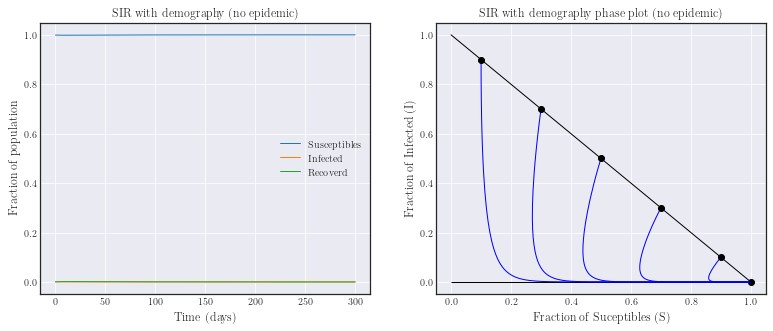

In [9]:
# set parameter values for no epidemic state
beta2_no_epidemic = 1 / 6
gamma2_no_epidemic = 1 / 3

# make plots
SIR_d_nep = plot_demo_SIR(demo_SIR, y0, t, beta2_no_epidemic, gamma2_no_epidemic, mu, "no epidemic")

### 2.2 Exercise 2

Add an infection induced mortality term to the model ($N_{population}$ $\neq$ constant), which will depend on some probability of dying while infected. What happens when the probability approaches 1?

In [10]:
def freq_ind_SIR(y, t, beta, gamma, theta, mu, rho):
    """
    Representation of ODE of SIR with demography
    and induced mortatility (frequency)
    """
    
    S, I, R = y
    dSdt = theta * n_sir_freq - beta * S * I / n_sir_freq - mu * S
    dIdt = beta * S * I / n_sir_freq - (((mu + gamma) * I) / (1 - rho))
    dRdt = gamma * I - mu * R
    
    
    return [dSdt, dIdt, dRdt]

def freq_ind_SIR_dynamics(ax, func, init_pop, t, beta, gamma, theta, mu, rho, state):
    """
    Plots the dynamics for a given SIR model with demography and
    induced mortatlity, initial populaiton, beta, gamma, theta and ro
    """
    # gives solution of ODE over a certain time interval for a given population, beta and gamma
    sol = odeint(func, init_pop, t, args=(beta, gamma, theta, mu, rho))

    # plot
    ax.plot(t, sol[:, 0] / n_sir_freq, label="Susceptibles")
    ax.plot(t, sol[:, 1] / n_sir_freq, label="Infected")
    ax.plot(t, sol[:, 2] / n_sir_freq, label="Recoverd")
    ax.legend(loc="best")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Fraction of population")
    ax.set_title(r"SIR with demography and induced mortality" "\n" "({ep})".format(ep = state))
    
    return sol

def freq_ind_SIR_phase(ax, func, t, beta, gamma, mu, theta, rho, state):
    """
    Phase plot for a given SIR model with demography and
    induced mortatlity, initial populaiton, beta, gamma, theta and ro
    (frequency)
    """
    
    # create vector for different initials values for infected
    I_first = 0.1 * n_sir_freq
    I_step = 0.2 * n_sir_freq
    I_all = np.arange(I_first, n_sir_freq, I_step)
    I_all = np.insert(I_all, 0, 0.001 * n_sir_freq)

    # makes phase plot for the different initial values of infected
    for I_init in I_all:
        S_init = n_sir_freq - I_init - R_freq
        y0 = [S_init, I_init, R_freq]
        sol = odeint(func, y0, t, args=(beta, gamma, theta, mu, rho))
        ax.plot(sol[:, 0] / n_sir_freq, sol[:, 1] / n_sir_freq, 'b-')
        ax.plot(sol[0,0] / n_sir_freq, sol[0,1] / n_sir_freq, 'ko')

    # create vector for different initials values for suceptibles
    # if there is an epidemic state make phase plot for the different inital values
#     S_first = ceil(((gamma + mu))/ (beta * (1 - rho)) * 10) / 10
    S_first = np.reciprocal((beta * (1 - rho)) / (gamma + mu))
    if S_first < 1:
        S_step = 0.2 * n_sir_freq
        S_all = np.arange(S_first * n_sir_freq, n_sir_freq, S_step)
        S_all = np.insert(S_all, len(S_all), 0.999 * n_sir_freq)

        # makes phase plot for the different initial values of suceptibles
        # only for epidemic state
        I_init = 0.001 * n_sir_freq
        for S_init in S_all:
            R_init = n_sir_freq - S_init - I_init
            y0 = [S_init, I_init, R_init]
            sol = odeint(func, y0, t, args=(beta, gamma, theta, mu, rho))
            ax.plot(sol[:, 0] / n_sir_freq, sol[:, 1] / n_sir_freq, 'b-')
            ax.plot(sol[0,0] / n_sir_freq, sol[0,1] / n_sir_freq, 'ko')
            ax.plot(sol[-1, 0] / n_sir_freq, sol[-1, 1] / n_sir_freq, "r.")
            
        # plot vertical line where (gamma + mu) / beta
        ax.vlines(S_first, 0.001, 1.05, colors='k', linestyles="dashed", linewidth=0.5)

    # creates diagonal line where R(0) = 0
    S_diagonal = [(n_sir_freq - I_init) / n_sir_freq for I_init in I_all]
    S_diagonal = np.array(S_diagonal[::-1])
    S_diagonal = np.insert(S_diagonal, 0, 0)
    I_diagonal = I_all[::-1] / n_sir_freq
    I_diagonal = np.insert(I_diagonal, 0, 1)
    ax.plot(S_diagonal, I_diagonal, 'k-')
    
    # creates horizontal line where I(0) = 0.001
    ax.hlines(0.001, 0, 1)
    
    # set limits axis and set title for axis and plot
    ax.set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))
    ax.set_xlabel("Fraction of Suceptibles (S)")
    ax.set_ylabel("Fraction of Infected (I)")
    ax.set_title(r"SIR with demography phase plot and induced mortality" "\n" "({ep})".format(ep = state))
    
def freq_ind_SIR_plot(func, init_pop, t, beta, gamma, theta, mu, rho):
    """
    Plots the SIR model for a given initial population, 
    beta and gamma over a certain amounnt of time steps.
    Also plots the phaseplot.
    """
    
    state = "no epidemic"
    test = False
    
    if np.reciprocal((beta * (1 - rho)) / (gamma + mu)) < 1:
        state = "epidemic"
        test = True
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 5)) 
    sol = freq_ind_SIR_dynamics(axes[0], func, init_pop, t, beta, gamma, theta, mu, rho, state)
    freq_ind_SIR_phase(axes[1], func, t, beta, gamma, theta, mu, rho, state)
    
    if test:
        plt.savefig(f"{rel_path}/SIR_with_demo_and_mort_ep{rho}.pdf", format="pdf", bbox_inches="tight", dpi=300)
    else:
        plt.savefig(f"{rel_path}/SIR_with_demo_and_mort_no_ep{rho}.pdf", format="pdf", bbox_inches="tight", dpi=300)
        
    fig.tight_layout()
    plt.show()
        
    return sol


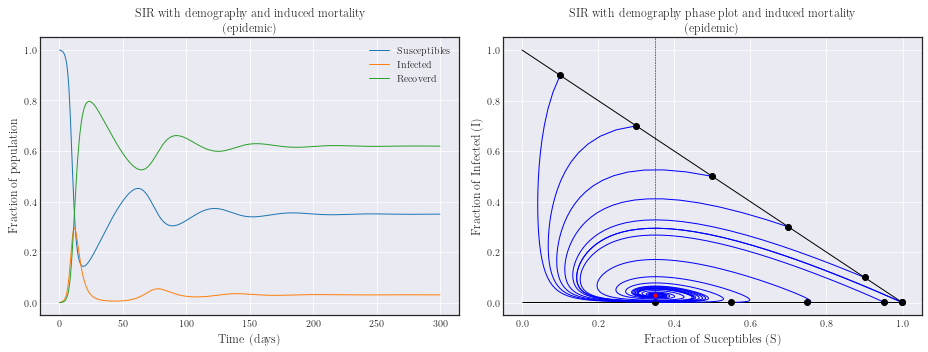

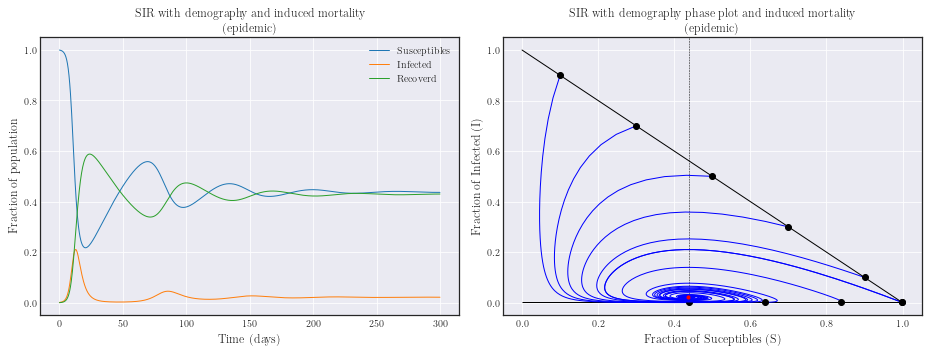

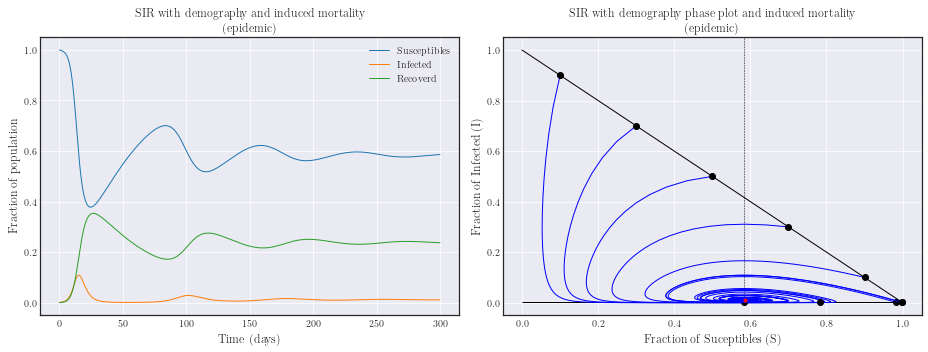

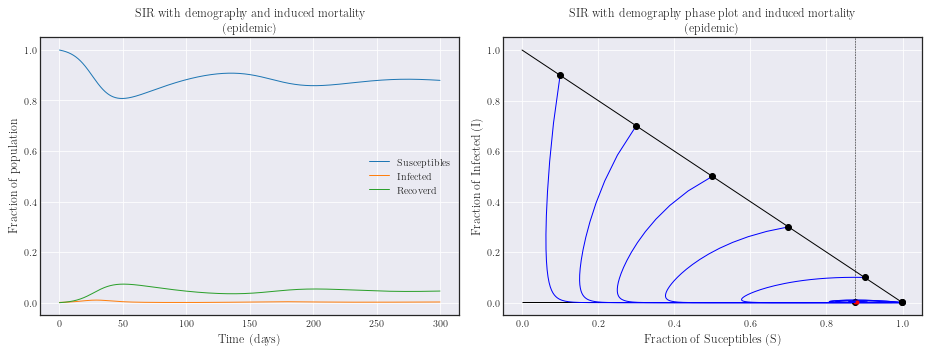

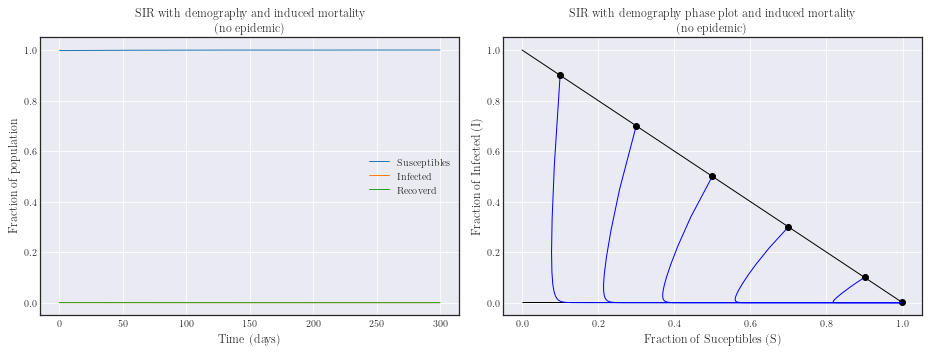

In [11]:
n_sir_freq = 1000000
I_freq, R_freq = 0.001 * n_sir_freq, 0
S_freq = n_sir_freq - I_freq - R_freq

y_freq = [S_freq, I_freq, R_freq]
rho_test = [0, 0.2, 0.4, 0.6, 0.8]
theta = mu

# make plots
for rho in rho_test:
    solution = freq_ind_SIR_plot(freq_ind_SIR, y_freq, t, 
                                 beta2_epidemic, gamma2_epidemic, 
                                 theta, mu, rho)

## Exercise 3

Pick a variation of the SIR model and provide similar detail and analysis used in the previous problems. Some examples can be SIER, MSIR, SEIS, MSEIR, MSEIRS etc. Add seasonal effects into the model you choose (Hint: add a time varying sinusoidal rate of infection).

For this part the SEIR model is implemented. First we construct the basic SEIR model with induced mortality. Subsequentely we introduce a time varying sinusiodal rate

In [12]:
def basic_SEIR(y, t, beta, sigma, gamma, mu):
    """
    Representation of ODE of SEIR with induced mortality.
    """
    
    S, E, I, R = y
    dSdt = mu * N - beta * S * I / N - mu * N
    dEdt = beta * S * I / N - (mu + sigma) * E
    dIdt = sigma * E - (mu + gamma) * I
    dRdt = gamma * I - mu * R
    
    
    return [dSdt, dEdt, dIdt, dRdt]

In [13]:
def plot_dyn_basic_SEIR(ax, func, init_pop, t, beta, sigma, gamma, mu, state):
    """
    Plots the dynamics for a given SEIR model, initial populaiton, 
    beta, sigma, gamma and mu
    """
    # gives solution of ODE over a certain time interval for a given population, beta and gamma
    sol = odeint(func, init_pop, t, args=(beta, sigma, gamma, mu))

    # plot
    ax.plot(t, sol[:, 0] / N, label="Susceptibles")
    ax.plot(t, sol[:, 1] / N, label="Exposed")
    ax.plot(t, sol[:, 2] / N, label="Infected")
    ax.plot(t, sol[:, 3] / N, label="Recovered")
    ax.legend(loc="upper right")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Fraction of population")
    ax.set_title(r"Basic SEIR with demography ({ep})".format(ep = state))
    
    return sol


def plot_basic_SEIR(ax, func, init_pop, t, beta, sigma, gamma, mu):
    """
    Plots the SIR model for a given initial population, 
    beta and gamma over a certain amounnt of time steps.
    Also plots the phaseplot.
    """

    state = "no epidemic"
    R_inv = ceil((((gamma + mu) / beta) * ((sigma + mu) / sigma)) * 10) / 10
    
    if R_inv < 1:
        state = "epidemic"
    
    sol = plot_dyn_basic_SEIR(ax, func, init_pop, t, beta, sigma, gamma, mu, state)
        
    return sol

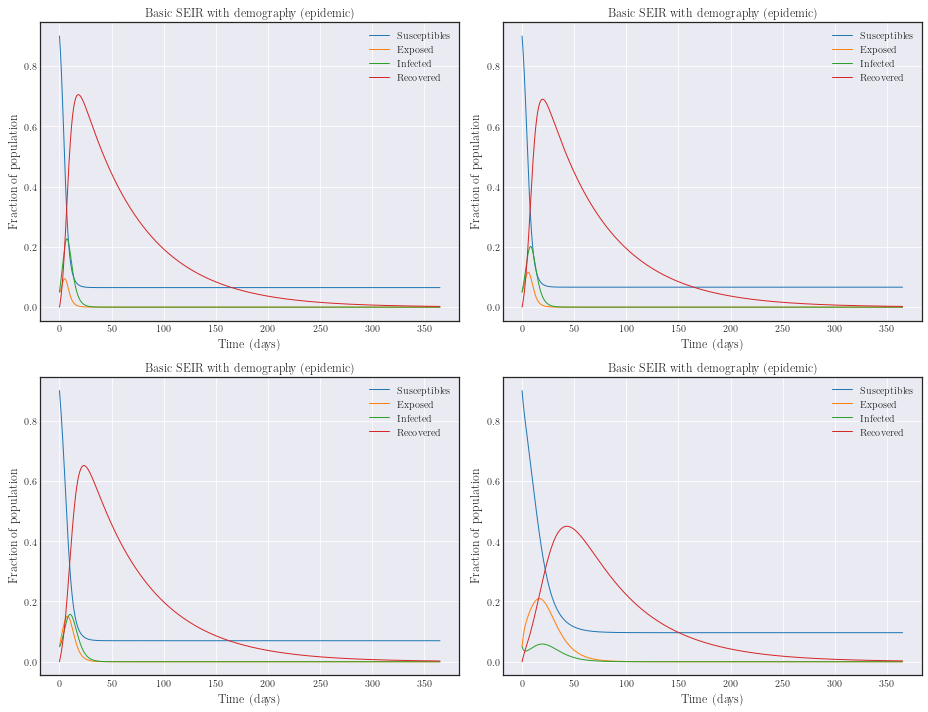

In [14]:
N = 1000
E0, I0, R0 = 0.05 * N, 0.05 * N, 0
S0 = N - E0 - I0 - R0
y0 = [S0, E0, I0, R0]

days = 365
years = 1
points = (days * years) * 2
t = np.linspace(0, days * years, points)

sigma_test = [(1, 0, 0), (0.7, 0, 1), (0.4, 1, 0), (0.1, 1, 1)]

fig, ax = plt.subplots(len(sigma_test) // 2, 2, figsize=(13, 10))

for sigma, row, col in sigma_test:
    solutions = plot_basic_SEIR(ax[row, col], basic_SEIR, y0, t, beta2_epidemic, sigma, gamma2_epidemic, mu)

plt.savefig(f"{rel_path}SEIR.pdf", format="pdf", bbox_inches="tight")
fig.tight_layout()
plt.show()

Now we introduce a time varying sinuisodal rate. From Keeling & Rohani equation 5.2 we set the time varying parameter $\beta$ to be a sinusoid of the form: \begin{equation} \beta(t) = \beta_{0}(1 + \beta_{1}\cos(\omega t)) \end{equation}

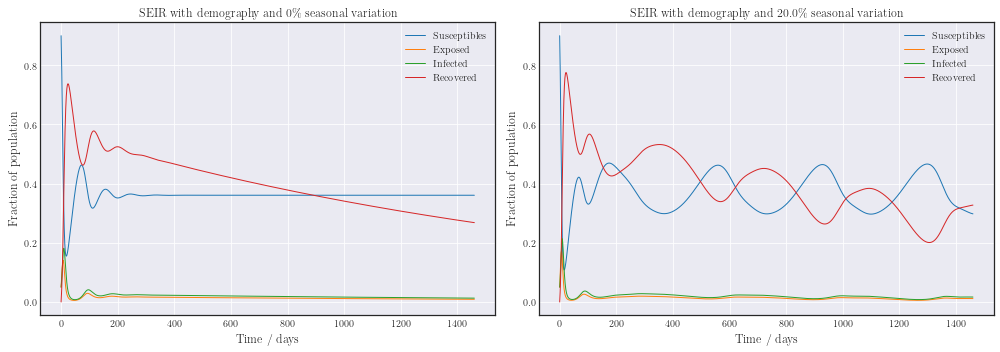

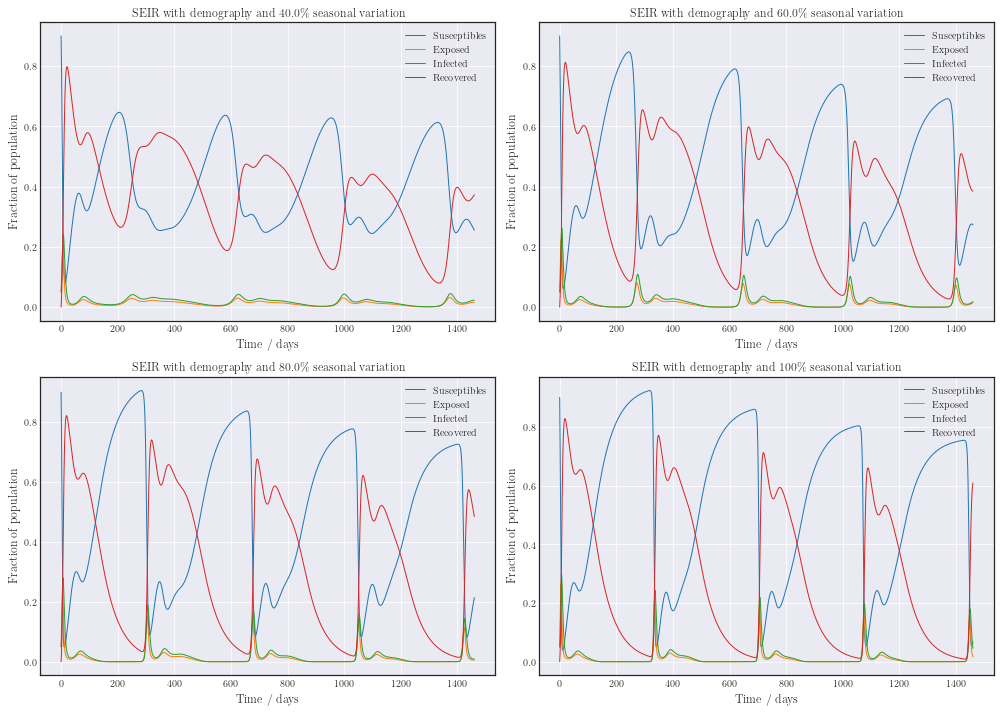

In [15]:
def seas_SEIR(y, t, beta, sigma, gamma, mu):
    """
    Representation of ODE of SEIR
    with induced mortality and
    a time varying sinuisodal rate.
    """
    
    S, E, I, R = y
    dSdt = mu * (I + R) - beta(t) * S * I / N 
    dEdt = beta(t) * S * I / N - (mu + sigma) * E
    dIdt = sigma * E - (mu + gamma) * I
    dRdt = gamma * I - mu * R
    
    
    return [dSdt, dEdt, dIdt, dRdt]

def beta_par(rate, period, omega):
    
    def beta(t):
        return rate * (1 + period * cos(2 * pi * omega * t))
    return beta

def plot_dyn_seas_SEIR(ax, func, init_pop, t, beta, sigma, gamma, mu, period):
    """
    Plots the dynamics for a given SEIR model, initial populaiton, 
    beta, sigma, gamma and mu
    """
    # gives solution of ODE over a certain time interval for a given population, beta and gamma
    sol = odeint(func, init_pop, t, args=(beta, sigma, gamma, mu))

    # plot
    ax.plot(t, sol[:, 0] / N, label="Susceptibles")
    ax.plot(t, sol[:, 1] / N, label="Exposed")
    ax.plot(t, sol[:, 2] / N, label="Infected")
    ax.plot(t, sol[:, 3] / N, label="Recovered")
    ax.legend(loc="upper right")
    ax.set_xlabel("Time / days", fontsize=12)
    ax.set_ylabel("Fraction of population", fontsize=12)
    ax.set_title(r"SEIR with demography and {period}\% seasonal variation".format(period = period * 100))
    
    return sol

def plot_seas_SEIR(ax, func, init_pop, t, beta, sigma, gamma, mu, period):
    """
    Plots the SIR model for a given initial population, 
    beta and gamma over a certain amounnt of time steps.
    Also plots the phaseplot.
    """
    

    sol = plot_dyn_seas_SEIR(ax, func, init_pop, t, beta, sigma, gamma, mu, period)
        
    return sol

# beta_SEIR = beta_par(1, 1 / 3, 1 / 365)
sigma = 0.5
rate = 1
omega = 1 / 365
days = 365
years = 4
points = (days * years) * 3 
t = np.linspace(0, days * years, points)

beta_test = [(0, 0), (0.2, 1)]
beta_test2 = [(0.4, 0, 0), (0.6, 0, 1), (0.8, 1, 0), (1, 1, 1)]

for period in beta_test:
    beta_time = beta_par(rate, period, omega)
    
# print(len(beta_test) // 2)
    
fig, ax = plt.subplots(len(beta_test) // 2, 2, figsize=(14, 5))
# print(ax[0])
for period, col in beta_test:
    beta = beta_par(rate, period, omega)
    solutions = plot_seas_SEIR(ax[col], seas_SEIR, y0, t, beta, sigma, gamma2_epidemic, mu, period)

fig.tight_layout()
plt.show()

fig, ax = plt.subplots(len(beta_test2) // 2, 2, figsize=(14, 10))
for period, row, col in beta_test2:
    beta = beta_par(rate, period, omega)
    solutions = plot_seas_SEIR(ax[row, col], seas_SEIR, y0, t, beta, sigma, gamma2_epidemic, mu, period)
    
fig.tight_layout()
plt.show()

### Fast Fourier Transform (FFT):

Final attempt FFT for both SIR model with induces mortality and both SEIR models

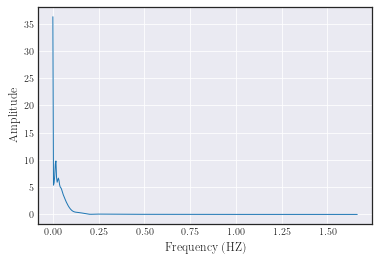

In [17]:
# variables for demographical SIR epidemic and no epidemic
samples = SIR_d_ep[:,1].size
SIR_ep_fft = fft(SIR_d_ep[:,1])
t = np.linspace(0, 300, 1000)
T = t[1] -t[0]
freq = np.linspace(0, 1 / T, samples)

plt.ylabel("Amplitude")
plt.xlabel("Frequency (HZ)")
# plt.bar(freq[:samples // 2], np.abs(SIR_ep_fft)[:samples // 2] * 1 / samples, width=1.5)
plt.plot(freq[:samples // 2], np.abs(SIR_ep_fft)[:samples // 2] * 1 / samples)
plt.show()